# Setting up Classes and Objects

In [1]:
# importing all relevant libraries

import heapq
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import random as rd
import scipy.stats as sts 
import pandas as pd
import math
import seaborn as sns

In [2]:
# Code copied from class session

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs


    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp


    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    

    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    

    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    

    def next_event_time(self):
        # Return the time of the next event. The `now` attribute of this class
        # contain the time of the last event that was run.
        return self.priority_queue[0].timestamp


    def run_next_event(self):
        #  the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp

        # print(f'At{event.timestamp: .2f}s: {event.function.__name__}')
        event.run(self)
        

    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [3]:
class Queue:
    def __init__(self, id, arrival_distribution = sts.expon(scale=1)):
        self.arrival_distribution = arrival_distribution
        self.passengers = []
        self.waiting_time = []
        self.stop_id = id
        self.max_queue_length = 0

    def remove(self, time):
        passenger = self.passengers.pop(0) # removes first passenger
        passenger.timestamp_embark(time)
        self.waiting_time.append(passenger.how_long())
        return passenger
    
    def customer_arrival(self, schedule: Schedule, time):
        passenger = Customer(starting_time = time, embark_stop = self.stop_id)
        self.passengers.append(passenger)
        next_arrival = self.arrival_distribution.rvs()
        self.max_queue_length = max(self.max_queue_length, len(self.passengers))
        schedule.add_event_after(next_arrival, self.customer_arrival, time + next_arrival)

    def run(self, schedule):
        next_arrival = self.arrival_distribution.rvs()
        schedule.add_event_after(next_arrival, self.customer_arrival, schedule.now + next_arrival)


In [4]:
class QueueSystem:
    def __init__(self, stops = 15,  arrival_distribution = sts.expon(scale=1)):
        self.stops = stops
        self.queues = [Queue(id, arrival_distribution) for id in range(stops)]

    def compute_metric1(self):
        total, time = 0,0
        for i in self.queues:
            total += np.sum(i.waiting_time)
            time += len(i.waiting_time)
        average = total/time
        return average

    def compute_metric2(self):
        length = 0
        for i in self.queues:
            length = max(i.max_queue_length, length)
        return length

    def run(self, schedule: Schedule):
        for queue in self.queues:
            queue.run(schedule)

In [5]:
class Bus:
    def __init__(self, id, current_stop, queue_system: QueueSystem,
                 max_capacity = 130, travel_distribution = sts.truncnorm(a=0, b=np.inf, loc=2, scale=0.5),
                disembark_distribution = sts.truncnorm(a=0, b=np.inf, loc=0.03, scale=0.01),
                embark_distribution = sts.truncnorm(a=0, b=np.inf, loc=0.05, scale=0.01)):
        
        self.id = id
        self.passengers_in_bus = 0
        self.served = 0
        self.current_stop = current_stop
        self.queue_system = queue_system
        self.stops = len(self.queue_system.queues)
        self.travel_distribution = travel_distribution
        self.disembark_distribution = disembark_distribution
        self.embark_distribution = embark_distribution
        self.max_capacity = max_capacity
        
        self.customer_stop = {i: list() for i in range(self.stops)} #dictionary of where each customer is going to stop

        
    def embarking(self, schedule):
        current_queue = self.queue_system.queues[self.current_stop]
        time = schedule.now
        
        empty_spots = self.max_capacity - self.passengers_in_bus
        queue_length = len(current_queue.passengers)
        
        n_embarking = min(empty_spots, queue_length)
        
        for i in range(n_embarking):
            time += self.embark_distribution.rvs()
            passenger = current_queue.remove(time)
            passenger.set_bus(self)
            disembark_stop = passenger.find_stop()
            self.customer_stop[disembark_stop].append(passenger)
            
        self.passengers_in_bus += n_embarking
        self.served += n_embarking
        at_time = time - schedule.now
        schedule.add_event_after(at_time, self.travel)

    def travel(self, schedule):
        self.current_stop = (self.current_stop + 1) % self.stops
        schedule.add_event_after(self.travel_distribution.rvs(), self.disembarking)

    def disembarking(self, schedule):
        time = schedule.now
        n_disembarking= len(self.customer_stop[self.current_stop])
        
        while self.customer_stop[self.current_stop]:
            time += self.disembark_distribution.rvs()
            passenger = self.customer_stop[self.current_stop].pop(0) # pop first element of disembarking list
            passenger.timestamp_disembark(time)
            
        self.passengers_in_bus -= n_disembarking
        at_time = time - schedule.now
        schedule.add_event_after(at_time, self.embarking)

    def run(self, schedule):
        schedule.add_event_after(0, self.embarking)

In [6]:
class BusSystem:
    def __init__(self, queue_system: QueueSystem, number_of_buses,max_capacity = 130,
                 travel_distribution = sts.truncnorm(a=0, b=np.inf, loc=2, scale=0.5),
                disembark_distribution = sts.truncnorm(a=0, b=np.inf, loc=0.03, scale=0.01),
                embark_distribution = sts.truncnorm(a=0, b=np.inf, loc=0.05, scale=0.01)):
        
        self.buses = []
        add = len(queue_system.queues) // number_of_buses
        
        for i in range(number_of_buses):
            self.buses.append(Bus(id = i, current_stop = add * i, travel_distribution = travel_distribution, 
                                  disembark_distribution = disembark_distribution, embark_distribution = embark_distribution,  
                                  max_capacity = max_capacity, queue_system = queue_system))

    def compute_metric3(self):
        total = 0
        for i in self.buses:
            total += i.served
        return total

    def run(self, schedule):
        for bus in self.buses:
            bus.run(schedule)

In [7]:
class Customer:
    def __init__(self, embark_stop, starting_time):
        self.starting_time = starting_time
        self.embark_stop = embark_stop
        self.embarking_time = 0
        self.disembark_stop = 0
        self.disembarking_time = 0
        self.bus: Bus = 0

    def find_stop(self):
        if not self.disembark_stop:
            stops = np.random.randint(1, self.bus.stops // 2 + 1)
            self.disembark_stop = (self.embark_stop + stops) % self.bus.stops
        return self.disembark_stop

    def timestamp_embark(self, time):
        self.embarking_time = time

    def timestamp_disembark(self, time):
        self.disembarking_time = time

    def how_long(self):
        return self.embarking_time - self.starting_time
    
    def set_bus(self, bus: Bus):
        self.bus = bus

# Running the Simulation

In [8]:
def run_simulation(no_of_buses, run_until):
    schedule = Schedule()
    
    queue_system = QueueSystem()
    queue_system.run(schedule)
    
    bus_system = BusSystem(queue_system, no_of_buses)
    bus_system.run(schedule)

    #run schedule until our marked end time
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    
    return queue_system, bus_system

In [9]:
#function for finding confidence interval
def calculate_confint(metric, interval = 0.95):
    lower, upper = sts.t.interval(alpha=interval, df=len(metric)-1,
                                  loc=np.mean(metric),scale=sts.sem(metric))
    
    confint = upper - np.mean(metric)
    
    return confint

# retrieve summary statistics 
def get_stats(no_of_buses, run_until = 360, trials = 100): #run until decides for how many minutes to run
    waiting_time = []
    queue_length = []
    served = []
    
    for i in range(trials):
        queue_system, bus_system = run_simulation(no_of_buses, run_until)
        
        #append results from queue system
        waiting_time.append(queue_system.compute_metric1())
        queue_length.append(queue_system.compute_metric2())
        
        #append results from bus system
        served.append(bus_system.compute_metric3())

    # First Performance Metric
    mean_waiting_time = np.mean(waiting_time)
    confint_waiting_time = calculate_confint(waiting_time)

     
    # Second Performance Metric
    max_queue_length = np.mean(queue_length)  
    confint_queue_length = calculate_confint(queue_length)

    #Third Performance Metric
    all_customers = np.mean(served)
    confint_passengers = calculate_confint(served)


    return mean_waiting_time, confint_waiting_time, max_queue_length, confint_queue_length, all_customers, confint_passengers

In [10]:
def experiment(number, trials):
    metric1 = []
    confint1 = []
    metric2 = []
    confint2 = []
    metric3 = []
    confint3 = []
    
    buses = range(1, number+1)
    
    for bus in buses:
        mean_waiting_time, confint_waiting_time, mean_queue_length, confint_queue_length, all_customers, confint_passengers = get_stats(bus, trials = trials)

        metric1.append(mean_waiting_time)
        confint1.append(confint_waiting_time)

        metric2.append(mean_queue_length)
        confint2.append(confint_queue_length)

        metric3.append(all_customers / bus) 
        confint3.append(confint_passengers)
    
    #get mean and confidence interval pairings
    wt = [metric1, confint1]
    ql = [metric2, confint2]
    tp = [metric3, confint3]
    
    return wt, ql, tp

In [44]:
met1, met2, met3 = experiment(15, 10)

# Plotting

In [45]:
def plotting(metric, number, string):
    plt.style.use('seaborn-whitegrid')
    axis = range(1, number+1)
    plt.figure(figsize = (10,5))
    plt.errorbar(axis, metric[0], yerr=metric[1], marker='o', linestyle='--', label='95% Confidence interval')
    plt.ylim(ymin=0)
    plt.xlabel("Buses")
    plt.ylabel(string)
    plt.legend()
    plt.show()    

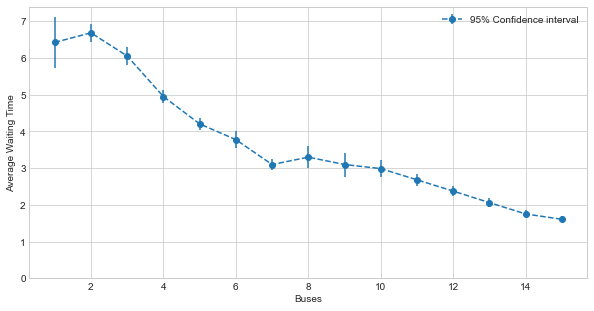

In [46]:
plotting(met1, 15, "Average Waiting Time")

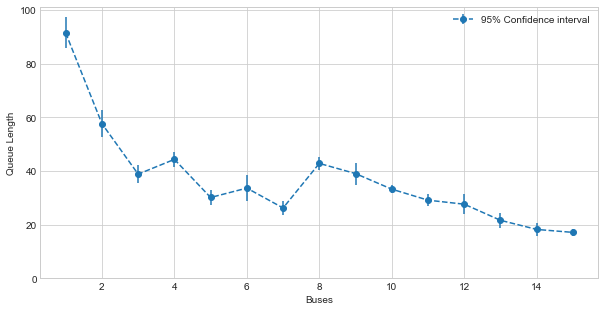

In [53]:
plotting(met2, 15, "Queue Length")

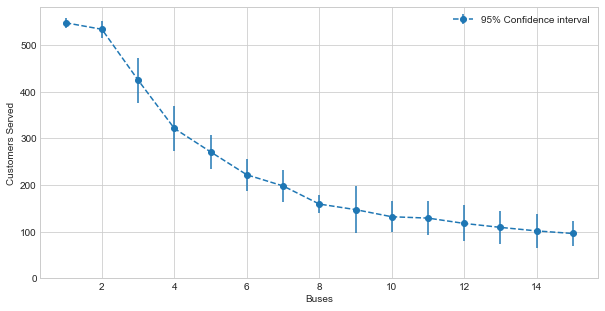

In [55]:
plotting(met3, 15, "Customers Served")

In [97]:
print(f"""
Expected Value for Average Waiting Time: {round(met1[0][6],2)} minutes
Confidence Interval: {[met1[0][6] - met1[1][6], met1[0][6] + met1[1][6] ]}""")

print(f"""
Expected Value for Maximum Queue Length: {round(met2[0][6],2)} customers
Confidence Interval: {[met2[0][6] - met2[1][6], met2[0][6] + met2[1][6] ]}""")

print(f"""
Expected Value Customers Served per bus: {round(met3[0][6],2)} customers
Confidence Interval: {[met3[0][6] - met3[1][6], met3[0][6] + met3[1][6] ]}""")


Expected Value for Average Waiting Time: 5.11 minutes
Confidence Interval: [4.902792938861304, 5.309763795571615]

Expected Value for Maximum Queue Length: 26.2 customers
Confidence Interval: [23.658496658170762, 28.741503341829237]

Expected Value Customers Served per bus: 197.9 customers
Confidence Interval: [164.2823689956987, 231.5176310043013]
